<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/07_segmentation_light_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сегментация изображений

Есть [фреймворк моделей сегментации](https://github.com/qubvel/segmentation_models). Обучить сеть Unet или на одном из следующих датасетов:
* [Cityscapes](https://www.cityscapes-dataset.com/) 
* https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJh.. 

# Подготовка окружения

In [1]:
!pip install segmentation-models

In [2]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.metrics import iou_score, f_score
from segmentation_models.losses import bce_jaccard_loss, jaccard_loss, dice_loss

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K

import tensorflow.image as img

from IPython.display import Image
import matplotlib.pyplot as plt

import numpy as np
import glob
import imageio

# Утилиты
def read_image(filename):
    return imageio.imread(filename)

def display_image(filename):
    with open(filename,'rb') as f:
        display(Image(data=f.read(), format='png'))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


# Подготовка входных данных

## Подготовка файловой структуры

In [5]:
!unzip dataset1.zip

Archive:  dataset1.zip
   creating: dataset1/
   creating: dataset1/annotations_prepped_test/
 extracting: dataset1/annotations_prepped_test/0016E5_08085.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08039.png  
 extracting: dataset1/annotations_prepped_test/0016E5_07995.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08067.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08073.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08123.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08159.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08157.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08047.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08075.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08121.png  
 extracting: dataset1/annotations_prepped_test/0016E5_08053.png  
  inflating: dataset1/annotations_prepped_test/0016E5_08119.png  
  inflating: dataset1/annotations_prepped_test/0

In [0]:
!mkdir train_images
!mv dataset1/images_prepped_train train_images

!mkdir train_annotations
!mv dataset1/annotations_prepped_train train_annotations

!mkdir test_images
!mv dataset1/images_prepped_test test_images

!mkdir test_annotations
!mv dataset1/annotations_prepped_test test_annotations

## Входные параметры

In [0]:
K.clear_session()

# Пути к изображениям
train_image_dir = 'train_images'
train_annotation_dir = 'train_annotations'

test_image_dir = 'test_images'
test_annotation_dir = 'test_annotations'

image_files = glob.glob(train_image_dir + "/images_prepped_train/*.png") 
annotation_files = glob.glob(train_annotation_dir + "/annotations_prepped_train/*.png") 

# Размеры изображений
image_height, image_width = 360, 480
target_height, target_width = 352, 480

orig_size = (image_height, image_width)
target_size = (target_height, target_width)
target_shape = (target_height, target_width, 3)

# Типы сегментов
num_classes = 12

# Другое
batch_size = 6
steps_per_epoch = len(image_files) / batch_size
val_steps_per_epoch = len(annotation_files) / batch_size

## Просмотр изображений

train_images/images_prepped_train/0006R0_f02730.png


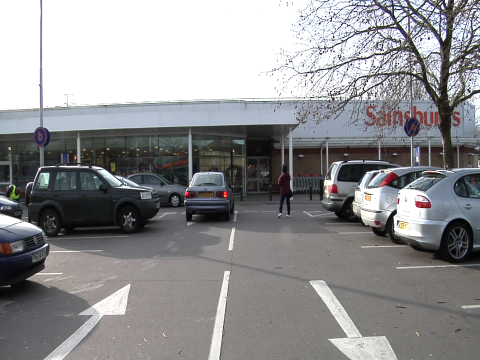

(360, 480, 3)
train_annotations/annotations_prepped_train/0006R0_f02730.png


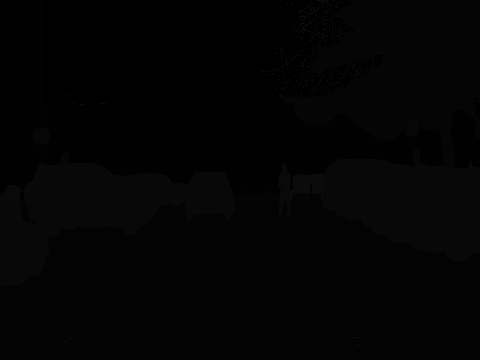

(360, 480)


In [8]:
idx = 15

# Image
filename = image_files[idx]
print(filename)
display_image(filename)

content = read_image(filename)
print(content.shape)

# Annotation
filename = annotation_files[idx]
print(filename)
with open(filename,'rb') as f:
    display(Image(data=f.read(), format='png'))

ann = read_image(filename)
print(ann.shape)

## Генератор входных изображений

In [0]:
def crop(batch_images): 
    dh = (image_height - target_height) // 2
    dw = (image_width - target_width) // 2   
    return batch_images[:, dh:(image_height - dh), dw:(image_width - dw),:]

def prepare_image(image):
    return crop(image)

def prepare_label(label):
    label = crop(label)
    label = label[:,:,:,0]
    label = to_categorical(label, num_classes = num_classes)
    return label

def create_generator(args, folder, seed):
    return ImageDataGenerator(**args).flow_from_directory(
        folder,
        target_size = orig_size,
        batch_size = batch_size,
        class_mode=None,
        seed = seed)
        
def create_combined_generator(image_dir, annotation_dir, seed):
    image_generator = create_generator(dict(), image_dir, seed)
    label_generator = create_generator(dict(), annotation_dir, seed)
    
    combined = zip(image_generator, label_generator)
    
    for image, label in combined:
        yield (prepare_image(image), prepare_label(label))

# Создание и тренировка нейросети

In [5]:
train_gen = create_combined_generator(train_image_dir, train_annotation_dir, 100)
val_gen = create_combined_generator(test_image_dir, test_annotation_dir, 200)
loss = dice_loss
metrics = f_score

optimizer = Adam(lr=5e-4)
model = Unet('resnet34', input_shape=target_shape, encoder_weights='imagenet', classes=num_classes, activation='softmax')
model.compile(optimizer, loss=loss, metrics=[metrics])

history = model.fit_generator(
    train_gen,
    epochs = 30,
    steps_per_epoch = steps_per_epoch,
    verbose = 1,
    validation_data = val_gen, 
    validation_steps = val_steps_per_epoch,
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/30
Found 101 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
62/61 [==============================] - 84s 1s/step - loss: 0.7493 - f_score: 0.2507 - val_loss: 0.7557 - val_f_score: 0.2443
Epoch 2/30
62/61 [==============================] - 65s 1s/step - loss: 0.6042 - f_score: 0.3958 - val_loss: 0.6466 - val_f_score: 0.3534
Epoch 3/30
62/61 [==============================] - 65s 1s/step - loss: 0.5405 - f_score: 0.4595 - val_loss: 0.5626 - val_f_score: 0.4374
Epoch 4/30
62/61 [==============================] - 65s 1s/step - loss: 0.5066 - f_score: 0.4934 - val_loss: 0.5561 - val_f_score: 0.4439
Epoch 5/30
62/61 [==============================] - 65s 1s/step - loss: 0.4745 - f_sco

In [7]:
model.compile('sgd', loss=loss, metrics=[metrics])
model.fit_generator(
    train_gen,
    epochs = 5,
    steps_per_epoch = steps_per_epoch,
    verbose = 1,
    validation_data = val_gen, 
    validation_steps = val_steps_per_epoch,
)

Epoch 1/5
62/61 [==============================] - 70s 1s/step - loss: 0.2431 - f_score: 0.7569 - val_loss: 0.2469 - val_f_score: 0.7531
Epoch 2/5
62/61 [==============================] - 62s 994ms/step - loss: 0.2361 - f_score: 0.7639 - val_loss: 0.2427 - val_f_score: 0.7573
Epoch 3/5
62/61 [==============================] - 62s 993ms/step - loss: 0.2412 - f_score: 0.7588 - val_loss: 0.2418 - val_f_score: 0.7582
Epoch 4/5
62/61 [==============================] - 62s 994ms/step - loss: 0.2372 - f_score: 0.7628 - val_loss: 0.2411 - val_f_score: 0.7589
Epoch 5/5
62/61 [==============================] - 62s 994ms/step - loss: 0.2385 - f_score: 0.7615 - val_loss: 0.2407 - val_f_score: 0.7593


# Демонстрация работы

## Утилиты

In [0]:
colors = [
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 0],
    [255, 165,0],
    [0, 128, 0],
    [0, 0, 128],
    [128, 128, 0],
    [0, 128, 128],
    [128, 0, 128],
    [128, 128, 128],
    [0, 255, 255],
    [210, 105, 30]
]

def predict_single_image(content):
    x = content
    x = np.expand_dims(x, axis=0)
    x = crop(x)
    
    prediction = model.predict(x)
    segmented = np.argmax(prediction, axis=-1)
    return segmented

def save_segmented_file(segmented, filename):
    shape = segmented.shape
    target_shape = (shape[1], shape[2], 3)
    print("Target shape: ", target_shape)
    segmented = np.reshape(segmented, shape[0] * shape[1] * shape[2])
    
    rgb = map(lambda x: colors[x], segmented)
    rgb = np.array(list(rgb))
    rgb = np.reshape(rgb, target_shape)
    
    imageio.imwrite(filename, rgb)
    
def extract_classes(pic):
    unique, counts = np.unique(pic, return_counts = True)
    
def plot_classes(pic, label):
    unique, counts = np.unique(pic, return_counts = True)
    plt.plot(unique, counts, label=label)
    
def predict_and_demonstrate(idx):
    predicted_filename = "%s_predicted.jpg" % idx
    annotated_filename = "%s_annotated.jpg" % idx
    
    # source
    source_image_filename = image_files[idx]
    content = read_image(source_image_filename)

    # annnotation
    source_annotation_filename = annotation_files[idx]
    ann = read_image(source_annotation_filename)
    ann_prepared = np.expand_dims(ann, axis = 0)
    save_segmented_file(ann_prepared, annotated_filename)
    
    prediction = predict_single_image(content)
    save_segmented_file (prediction, predicted_filename)
    
    print("Source")
    display_image(source_image_filename)
    
    print("Expected")
    display_image(annotated_filename)
    
    print("Actual")
    display_image(predicted_filename)
    
    # classes counts in original and predicted
    print("Classes counts")
    plot_classes(ann_prepared, "Original")
    plot_classes(prediction, "Predicted") 

    plt.legend()
    plt.show()

## Результаты работы

Target shape:  (360, 480, 3)


Target shape:  (352, 480, 3)
Source


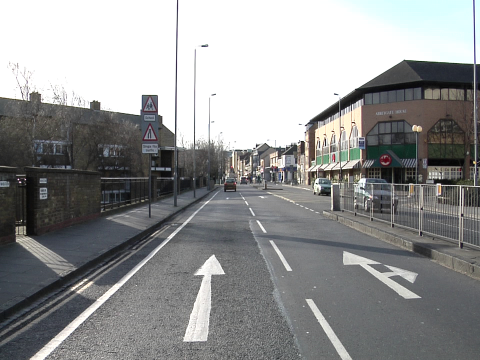

Expected


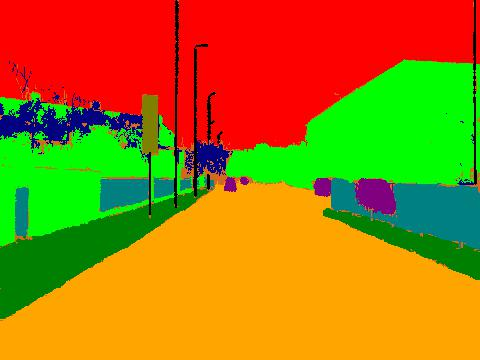

Actual


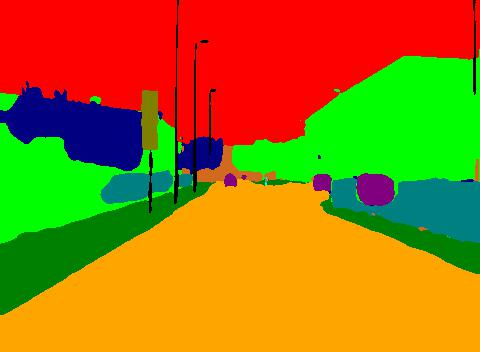

Classes counts


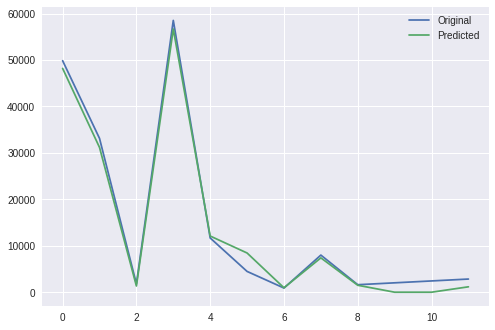

In [63]:
predict_and_demonstrate(300)